## Downloading and Importing Relevant Libraries

!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet
!pip3 install keras-tuner --quiet

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

## Downloading NVDA Stock Data

In [20]:
ticker = "NVDA" 
start_date = "2015-01-01"

nvda = yf.Ticker(ticker)
nvda = nvda.history(start=start_date)

nvda.index = pd.to_datetime(nvda.index)
nvda.index = nvda.index.date
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000,0.0,0.0
2015-01-05,0.483143,0.484584,0.472823,0.474983,197952000,0.0,0.0
2015-01-06,0.475703,0.476183,0.460102,0.460582,197764000,0.0,0.0
2015-01-07,0.463943,0.468023,0.457942,0.459382,321808000,0.0,0.0
2015-01-08,0.464663,0.479543,0.464423,0.476663,283780000,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-07,153.029999,153.130005,140.009995,140.139999,351782200,0.0,0.0
2025-01-08,142.580002,143.949997,137.559998,140.110001,227349900,0.0,0.0
2025-01-10,137.449997,139.919998,134.220001,135.910004,207602500,0.0,0.0
2025-01-13,129.990005,133.490005,129.509995,133.229996,204808900,0.0,0.0


## **Data Preprocessing**

**Feature Engineering** — After conducting feature engineering, I found that the LSTM performs the best when given just one feature—the closing price of the stock. I extracted this feature, stored it in a separate numpy array, and reshaped it to fit the input dimensions of the LSTM model architecture. 

**Data Scaling** — LSTMs are sensitive to the scale of the data; therefore, we need to apply the MinMax Scalar to normalize the data. This is important since stocks are volatile, and prices can vary greatly in a given timeframe. Feeding the LSTM with unnormalized data can cause it to struggle to learn relevant patterns and accurately predict the closing price of the stock.

**Data Splitting** — The training and test sets were split 70-30, while the validation set was split 80-20. The MinMax scaler was applied after splitting the data set to prevent data leakage.

In [21]:
nvda_close = nvda['Close'].values
nvda_close = np.array(nvda_close).reshape(-1, 1)

num_features = 1

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes MinMax scalar that scales values from 0 to 1 

In [23]:
# Splits the data into the training and testing set in a 70-30 split
train_val_set = nvda_close[:int(0.7 * len(nvda_close))] 
test_set = nvda_close[int(0.7 * len(nvda_close)):]

# Normalizing the training and testing set
training_val_scaled = scaler.fit_transform(train_val_set)
test_scaled = scaler.fit_transform(test_set)

In [24]:
# Splits the training and validation sets
training_scaled = training_val_scaled[:int(0.8 * len(training_val_scaled))]
val_scaled = training_val_scaled[int(0.8 * len(training_val_scaled)):]

### **Building Sequences**

One of the major strengths of an LSTM compared to other machine learning models is its ability to use historical prices to predict the future price of a stock. In this case, we're using a lookback value of 30, which means we're building sequences of historical closing prices from the past month for the LSTM. This helps the LSTM learn both short-term and long-term patterns, which helps it make better predictions for the future.

In [25]:
def build_sequences(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
        input = data[i : i + lookback]
        target = data[i + lookback]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [26]:
lookback = 30 # Setting the lookback value of 30 (prices from the past month)

# Building train, validation, and test set sequences
X_train, Y_train = build_sequences(training_scaled, lookback)
X_val, Y_val = build_sequences(val_scaled, lookback)
X_test, Y_test = build_sequences(test_scaled, lookback)

In [27]:
# Reshaping the datasets because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], num_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], num_features)

## **Building a Stacked LSTM Model with Hyperparameter Tuning**

A stacked LSTM model was used because it is designed to capture more complex and hierarchical temporal patterns in sequential data, such as stock data. By stacking multiple layers (in this case, we stacked 3 layers), the model can learn more intricate patterns and both short-term and long-term trends. While stacked LSTMs are more computationally expensive, they generally outperform single-layer models by learning deeper, nuanced relationships in the data, which can be extremely useful when predicting complex trends like the ones seen in stocks.

##### **Hyperparameter tuning was done to 3 aspects of the LSTM model: units, dropout rate, and the learning rate.**

The units represent the number of neurons in each LSTM layer, tuned from 100 to 150 in steps of 5. Striking the balance is crucial because too many neurons might lead to the model overfitting (when the model essentially memorizes the training set and fails to generalize on unseen data). At the same time, having too few neurons means that the model can't learn all the trends in the data.

The dropout rate is a regularization technique that counters overfitting by randomly setting a fraction of input units to 0 to prevent the model from relying too heavily on one node. In this case, it is tuned from 0.1 (10%) to 0.2 (20%) in steps of 0.05. Striking a balance is important because a value too low might lead to the model overfitting, and a value too high might lead to the model being unable to learn due to the lack of available neurons.

The learning rate determines how quickly the model learns by updating its weights during training. A small learning rate ensures more precise adjustments but can be computationally expensive. A larger learning rate might lead to the model learning too fast and skipping over important information, but it is computationally cheaper. In this case, it is tuned to pick one of these three choices: 1e-2, 1e-3, 1e-4.

##### **Hyperparameter Tuning using HyperBand**

HyperBand is an optimization algorithm that iteratively selects and evaluates different combinations of hyperparameters, allocating more resources to the most promising candidates while quickly discarding underperforming ones. Instead of exhaustively training every possible model, it starts by training many models with limited resources (like fewer epochs). It gradually focuses on the best-performing ones by allocating additional resources to them (like more epochs).

In [28]:
# Importing TensorFlow backend with Keras for building the LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

In [29]:
def lstm_model(hyper_params):
    model = Sequential() # Building a Sequential architecture that stacks LSTMs linearly
    units = hyper_params.Int('units', min_value = 100, max_value = 150, step = 5) # Number of neurons in each layer tuned from 100 to 150
    dropout_rate = hyper_params.Float('dropout_rate', min_value = 0.1, max_value = 0.2, step = 0.05) # Dropout rate tuned from 0.1 to 0.2
    learning_rate = hyper_params.Choice('learning_rate', [1e-2, 1e-3, 1e-4]) # Learning rate for the Adam optimizer tuned from these three choices

    model.add(layers.LSTM(units, return_sequences = True, input_shape = (None, num_features))) # First LSTM layer with defined units
    model.add(layers.LSTM(units, return_sequences = True)) # Second LSTM layer with defined units
    model.add(layers.LSTM(units)) # Third LSTM layer with defined units
    model.add(Dropout(dropout_rate)) # Adds a dropout layer to account for possible overfitting
    model.add(Dense(1)) # Adds a Dense layer with one output, which predicts one single value (the closing price tomorrow) from the input sequence 
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Defines the optimizer (Adam with tuned learning rate)
    model.compile(loss = 'mae', optimizer = optimizer) # Compiling the model using the 'mae' loss function and the optimizer defined above

    return model # Returns the Model

In [30]:
tuner = kt.Hyperband(
    lstm_model,
    objective='val_loss',  # Minimize validation loss
    max_epochs=5,  # Maximum number of Epochs
    directory='lstm-model',  # Directory to store the results
    project_name='lstm_tuning',  # Folder for storing this specific project
    overwrite=True, # Overwrites the directory with the latest trial run results
)

# Callbacks for Early Stopping to counter overfitting with a patience parameter of 3
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode = 'min', restore_best_weights=True)

# Fit the tuner to find the best hyperparameters for the model
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), callbacks=[early_stopping])

Trial 10 Complete [00h 00m 17s]
val_loss: 0.021452857181429863

Best val_loss So Far: 0.021452857181429863
Total elapsed time: 00h 02m 14s


In [31]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0] # Get the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters) # Build the best LSTM model using the highest performing hyperparameters

In [32]:
# Training the best LSTM model
history = best_model.fit(X_train, Y_train, epochs=100, batch_size = 10, validation_data=(X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0620 - val_loss: 0.0726
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0109 - val_loss: 0.0166
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0115 - val_loss: 0.0424
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0093 - val_loss: 0.0195
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0098 - val_loss: 0.0477


In [33]:
# Predicting the closing price on the test set using the best model
predictions_normalized = best_model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


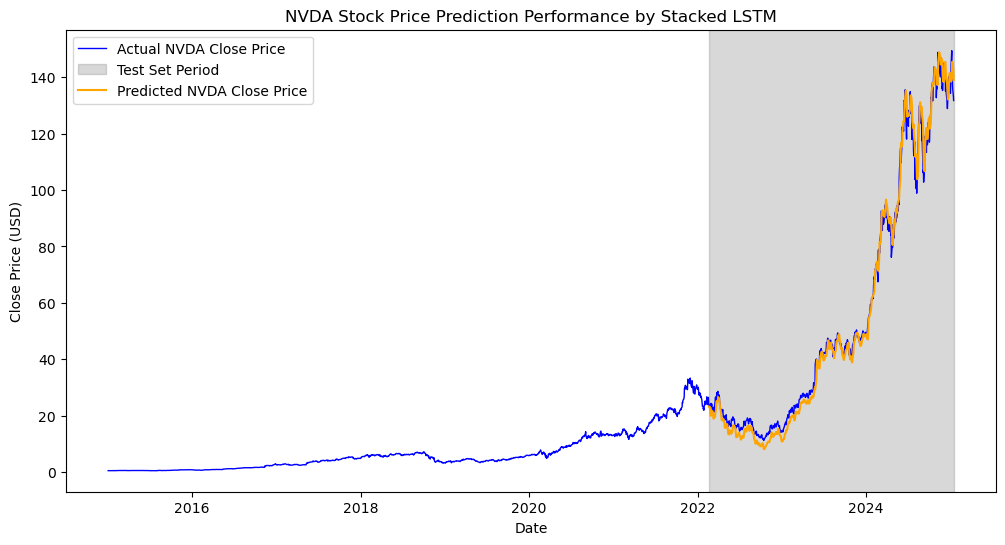

In [34]:
# Transforming our normalized prices back to their original scale, so they can be directly compared
predictions_actual = scaler.inverse_transform(predictions_normalized) 
y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

test_dates = nvda.index[-len(y_test_actual):] # Gets the date indexes for the test set

# Plots the LSTM performance on the overall dataset while also highlighting the test set
plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label=f'Actual {ticker} Close Price')
plt.axvspan(test_dates[0], test_dates[-1], color='gray', alpha=0.3, label='Test Set Period')
plt.plot(test_dates, predictions_actual, color = 'orange', label=f'Predicted {ticker} Close Price')
plt.title(f'{ticker} Stock Price Prediction Performance by Stacked LSTM')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

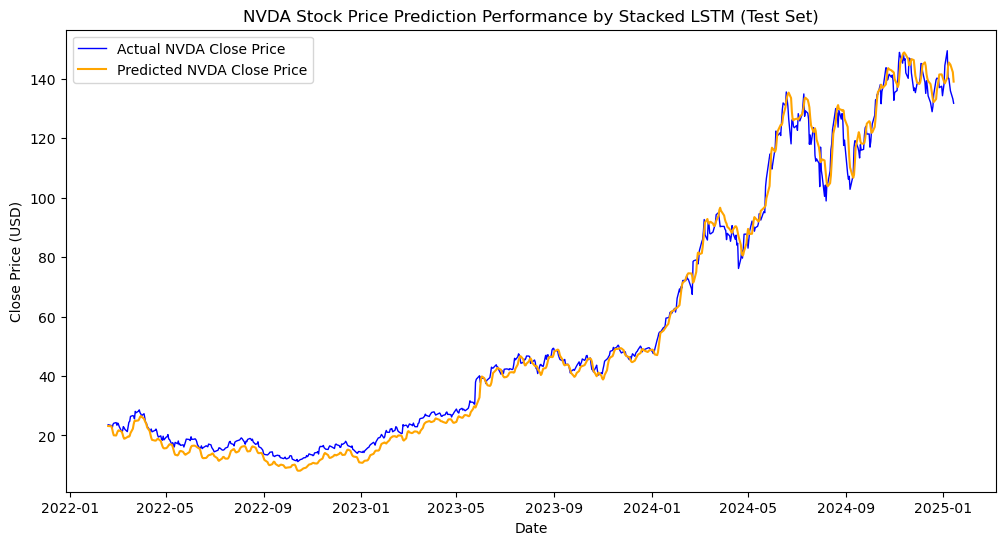

In [35]:
# Plots the LSTM performance on the test set
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, color='blue', linewidth=1, label=f'Actual {ticker} Close Price')
plt.plot(test_dates, predictions_actual, color = 'orange', label=f'Predicted {ticker} Close Price')
plt.title(f'{ticker} Stock Price Prediction Performance by Stacked LSTM (Test Set)')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print("Root Mean Squared Error: "+ str(root_mean_squared_error(y_test_actual, predictions_actual)))
print("Mean Absolute Error: "+ str(mean_absolute_error(y_test_actual, predictions_actual)))
print("R-Squared: "+ str(r2_score(y_test_actual, predictions_actual)))
print("Mean Absolute Percentage Error: " + str(mean_absolute_percentage_error(y_test_actual, predictions_actual)))

Root Mean Squared Error: 3.5833111443890635
Mean Absolute Error: 2.867411990742107
R-Squared: 0.9931473837087079
Mean Absolute Percentage Error: 0.08575889438485425
